# Project Chicago: Transform ResStock UPGRADE Results to 15 SFD prototypes (Elevate Energy)
Created on: 12/15/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/resstock/files


### Download results from S3 or Eagle
://S3/resbldg-datasets/chicagoeui

In [2]:
# local path to downloaded results
iteration = '01' # <----- options: '01'
iter_path = f'cookcnty_upgrades_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir,iter_path)
print(f'Result path: {result_path}')


Result path: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_01


### Functions

In [48]:
def add_sqft_eui(df):
    global res
    sqft_map = {'0-499': 328,
                '500-749': 633,
                '750-999': 885,
                '1000-1499': 1220,
                '1500-1999': 1690,
                '2000-2499': 2176,
                '2500-2999': 2663,
                '3000-3999': 3301,
                '4000+': 8194}

    df['sqft'] = res['build_existing_model.geometry_floor_area'].map(sqft_map)
    df['gas_eui'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    return df

print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, slice_by_df, row):
    """
    df: df to slice on
    slice_by_df: df used to do the slicing
    """
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i

print('func loaded: "get_res_by_prototype"')

func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"


### 1. BASELINE results

In [70]:
save_a_copy_in_csv = False # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))
if save_a_copy_in_csv:
    res.to_csv(os.path.join(result_path,'baseline','results_up00.csv'))
res

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_maximum_daily_use_overlap_kw,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw
0,1,27,2020-12-15 23:54:16,2020-12-15 23:55:44,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,11.562108,3.767962,2.108069,2.530209,16.909091,18.545455,18.585986,14.853667,4697.0,20.743684
1,2,35,2020-12-15 23:38:31,2020-12-15 23:40:09,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,7.794705,2.175635,2.573825,1.685164,14.727273,18.545455,17.924759,9.109371,4791.0,21.032739
2,3,87,2020-12-15 23:10:22,2020-12-15 23:11:46,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,6.520155,1.764613,1.993336,1.401891,16.272727,18.090909,14.121335,11.013050,4742.0,17.635847
3,4,199,2020-12-15 23:37:29,2020-12-15 23:38:52,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,7.025083,2.969353,2.850159,2.750990,16.272727,18.545455,11.852284,9.437454,4790.0,13.289626
4,5,33,2020-12-15 23:17:23,2020-12-15 23:18:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,10.794713,2.696617,7.398642,2.180740,16.272727,13.454545,17.982806,29.960426,618.0,32.823039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,69,2020-12-15 22:16:33,2020-12-15 22:18:04,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.804342,1.514787,1.870035,1.243423,15.181818,15.272727,30.138113,18.723951,5176.0,34.545764
16773,16774,166,2020-12-15 22:09:08,2020-12-15 22:10:35,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,8.288546,2.986164,2.704836,2.621304,15.090909,16.090909,18.726779,12.475163,4743.0,23.235783
16774,16775,140,2020-12-16 00:00:50,2020-12-16 00:02:18,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.374493,1.344665,1.149184,1.259564,15.909091,17.181818,23.082375,7.591218,4768.0,25.659049
16775,16776,244,2020-12-16 00:18:27,2020-12-16 00:20:09,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.742586,10.081962,2.159651,2.974590,15.909091,18.727273,46.354349,13.542630,4791.0,53.196064


In [71]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [72]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_upgrades_01 - BASELINE result summary:

  * 16753 / 16777 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.669134
2            0.305199
3            0.025667
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.544858
WoodStud     0.455142
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.357548
1960-79      0.265147
1980-99      0.100937
2000-09      0.044589
2010s        0.006447
<1940        0.225333
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.828687
Heat Pump      0.006029
None           0.010923
Room AC        0.154360
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASHP    

### 1.2. Add additional metrics to Baseline

In [73]:
# (1) get sqft, gas/elec/site eui
res = add_sqft_eui(res)

# (2) aggregate heating and cooling end uses in ResStock results
res['total_gas_heating'] = res['simulation_output_report.natural_gas_central_system_heating_therm'] +\
    res['simulation_output_report.natural_gas_heating_therm']

res['total_elec_heating'] = res['simulation_output_report.electricity_central_system_heating_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_heating_kwh'] +\
    res['simulation_output_report.electricity_fans_heating_kwh'] +\
    res['simulation_output_report.electricity_heating_kwh'] +\
    res['simulation_output_report.electricity_pumps_heating_kwh']

res['total_elec_cooling'] = res['simulation_output_report.electricity_central_system_cooling_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_cooling_kwh'] +\
    res['simulation_output_report.electricity_cooling_kwh'] +\
    res['simulation_output_report.electricity_fans_cooling_kwh'] +\
    res['simulation_output_report.electricity_pumps_cooling_kwh']

## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui,total_gas_heating,total_elec_heating,total_elec_cooling,vintage_ee,stories
0,1,27,2020-12-15 23:54:16,2020-12-15 23:55:44,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,20.743684,885.0,1.147362,11.142590,152.728881,642.139144,0.000000,1830.084576,2: 1942-1978,1: <2 stories
1,2,35,2020-12-15 23:38:31,2020-12-15 23:40:09,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,21.032739,3301.0,0.456519,3.047444,56.039339,1272.791202,1050.107151,2732.180807,3: post-1978,2: 2+ stories
2,3,87,2020-12-15 23:10:22,2020-12-15 23:11:46,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,17.635847,1690.0,0.679216,4.243502,82.384863,936.514162,747.775468,1011.999861,3: post-1978,2: 2+ stories
3,4,199,2020-12-15 23:37:29,2020-12-15 23:38:52,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,13.289626,2176.0,0.574673,4.678334,73.416766,843.126544,91.309419,981.346347,2: 1942-1978,1: <2 stories
4,5,33,2020-12-15 23:17:23,2020-12-15 23:18:42,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,32.823039,1690.0,0.000000,11.732754,40.033788,0.000000,8942.899697,1845.669229,3: post-1978,1: <2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,69,2020-12-15 22:16:33,2020-12-15 22:18:04,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,34.545764,2176.0,0.774068,4.287429,92.017685,1504.377451,1142.576526,3349.089799,1: pre-1942,2: 2+ stories
16773,16774,166,2020-12-15 22:09:08,2020-12-15 22:10:35,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,23.235783,1220.0,1.700816,8.513977,199.091969,1657.466672,117.089657,1540.047585,1: pre-1942,2: 2+ stories
16774,16775,140,2020-12-16 00:00:50,2020-12-16 00:02:18,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,25.659049,1690.0,1.357662,5.079672,153.066405,2162.769461,0.000000,3659.888076,1: pre-1942,2: 2+ stories
16775,16776,244,2020-12-16 00:18:27,2020-12-16 00:20:09,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,53.196064,8194.0,0.438436,2.231105,51.446028,3352.227538,119.984892,9375.678254,1: pre-1942,2: 2+ stories


### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [74]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [75]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [76]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [77]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui', 
               'median elec eui': 'elec_eui'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui', 
               'mean elec eui': 'elec_eui'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2394.582482,814.176472,896.130572,0.404468,0.438007,8455.592702,9505.954959,4.043285,4.686193
2,Masonry All Years Split Level,1690.0,2000.196867,1160.188446,1286.125621,0.693515,0.736299,8691.571351,10070.159308,5.107963,5.887168
3,Masonry Post-1978 2 or more stories,3301.0,4058.270428,1331.608504,1366.549171,0.386128,0.418799,11165.891658,13064.823711,3.400469,3.869550
4,Masonry 1942-1978 Less than 2 Stories,1690.0,1680.132653,1041.965863,1136.678116,0.690638,0.723748,8219.999688,9273.251974,5.317172,6.075353
5,Masonry 1942-1978 2 or more stories,2176.0,2392.638539,1585.851757,1670.642756,0.756901,0.785800,9836.595137,11514.445533,4.715166,5.582743
6,Masonry Pre-1942 less than 2 stories,1220.0,1460.060606,1362.174432,1433.432084,1.018897,1.061736,8385.192118,9471.866519,6.422198,7.091857
7,Masonry Pre-1942 2 or more stories,2176.0,2552.909881,1818.719734,1974.210000,0.872846,0.910926,10400.016137,12793.554780,4.945490,6.097888
8,Frame Post-1978 Less than 2 stories,2176.0,2243.300336,857.015417,938.155517,0.458100,0.480878,8409.295904,9527.363743,4.423384,4.976688
9,Frame Post-1978 Split Level,2176.0,3012.053452,1098.217867,1221.660548,0.466244,0.484808,9431.754031,11368.459838,3.875454,4.567690


In [78]:
### (4) optional - get heating and cooling end uses to "groups"
Metric_map1 = ['frac_gas_heating', 'frac_elec_heating', 'frac_elec_cooling']
Metric_map2 = {'size_heating_kbut_h': 'simulation_output_report.size_heating_system_kbtu_h',
               'size_cooling_kbut_h': 'simulation_output_report.size_cooling_system_kbtu_h'}


for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row)
    
    ### (4.1) get fractions
    groups.loc[i, 'frac_gas_heating'] = res_group_i['total_gas_heating'].mean() / \
        res_group_i['simulation_output_report.total_site_natural_gas_therm'].mean()

    groups.loc[i, 'frac_elec_heating'] = res_group_i['total_elec_heating'].mean() / \
        res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    groups.loc[i, 'frac_elec_cooling'] = res_group_i['total_elec_cooling'].mean() / \
        res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    ### (4.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

print('(4) heating and cooling end uses computed')

(4) heating and cooling end uses computed


In [79]:
### (5) optional - get heating & cooling and floor area char breakdowns
House = []
House_chars = [cooling_col, heating_col,
              #'build_existing_model.geometry_floor_area',
              'build_existing_model.insulation_unfinished_attic']

for i, row in groups.iterrows():
    
    res_group_i = get_res_by_prototype(res, res, row)
    
    Ns = len(res_group_i)
    Hi = []
    for char in House_chars:
        Nchar = res_group_i.groupby(char)['building_id'].count()/Ns # fractions
        Nchar = Nchar.rename('fraction').to_frame()
        Nchar['housing_char'] = Nchar.index.name
        Hi.append(Nchar)
    
    Hi = pd.concat(Hi, axis=0)
    Hi.index.name = 'sub_char'
    Hi = Hi.reset_index()
    Hi['HousingGroupNo'] = row['HousingGroupNo']
    
    House.append(Hi)
    
House = pd.concat(House, axis=0)
House = pd.pivot_table(House, values='fraction', index=['HousingGroupNo'],
                    columns=['housing_char','sub_char'], aggfunc=np.sum)

print('(5) heating & cooling and floor area char breakdowns computed')

(5) heating & cooling and floor area char breakdowns computed


In [80]:
### Combine "groups" + "House" into "Out" for export
out = groups.drop(['Stories','WallType','Vintage'], axis=1)
out = pd.concat([out.set_index('HousingGroupNo')], axis=1, keys=['none']).join(House)

out

none  \
                                     HousingGroupName   
HousingGroupNo                                          
1               Masonry Post-1978 less than 2 stories   
2                       Masonry All Years Split Level   
3                 Masonry Post-1978 2 or more stories   
4               Masonry 1942-1978 Less than 2 Stories   
5                 Masonry 1942-1978 2 or more stories   
6                Masonry Pre-1942 less than 2 stories   
7                  Masonry Pre-1942 2 or more stories   
8                 Frame Post-1978 Less than 2 stories   
9                         Frame Post-1978 Split Level   
10                  Frame Post-1978 2 or more stories   
11                Frame 1942-1978 less than 2 stories   
12                         Frame Pre-1942 Split Level   
13                  Frame 1942-1978 2 or more stories   
14                 Frame Pre-1942 less than 2 stories   
15                   Frame Pre-1942 2 or more stories   

                                                                            \
               Non-normalized gas usage Non-normalized elec. usage   count   
HousingGroupNo                                                               
1                                  1133                      10282   685.0   
2                                  1416                       9661  9128.0   
3                                  1812                      18225   514.0   
4                                  1210                       8779  5488.0   
5                                  1427                      10549   794.0   
6                                  1504                       9299   726.0   
7                                  2044                      13272   921.0   
8                                  1054                       9353   596.0   
9                                  1168                      10445  1347.0   
10                                 1422                      13495   751.0   
11                                 1176                       9213  3012.0   
12                                 1297                       9964  2128.0   
13                                 1530                      12543  1138.0   
14                                 1340                       9103   703.0   
15                                 1753                      11967  1425.0   

                                                                            \
                 median gas   median elec Gas Diff-med(%) Elec Diff-med(%)   
HousingGroupNo                                                               
1                814.176472   8455.592702       28.139764        17.763152   
2               1160.188446   8691.571351       18.065788        10.034454   
3               1331.608504  11165.891658       26.511672        38.733105   
4               1041.965863   8219.999688       13.887119         6.367471   
5               1585.851757   9836.595137      -11.131868         6.753293   
6               1362.174432   8385.192118        9.429891         9.826948   
7               1818.719734  10400.016137       11.021539        21.639420   
8                857.015417   8409.295904       18.689239        10.089855   
9               1098.217867   9431.754031        5.974498         9.700775   
10              1341.786474  10584.482546        5.640895        21.567376   
11              1106.606380   8094.493818        5.900818        12.140521   
12              1797.643113   9418.223428      -38.600086         5.477485   
13              1690.251095   9622.460944      -10.473928        23.284215   
14              1417.258296   8167.086546       -5.765545        10.281374   
15              1965.872884  10003.147122      -12.143348        16.410570   

                                           ...  \
                   mean gas     mean elec  ...   
HousingGroupNo                             ...   
1                896.130572   9505.954959  ...   
2           

In [81]:
### export BASELINE prototype summary
out.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_01/baseline


## 2. UPGRADE summary ###

In [118]:
## count upgrades
N_upgrades = 0

for _, dirnames, _ in os.walk(os.path.join(result_path,'upgrades')):
    N_upgrades += len(dirnames)

print(f'>>> {iter_path} has {N_upgrades:,} upgrades')

## get summary table
summary_upgrades = []
for n in range(1, N_upgrades+1):
    nf = f'0{n}' if n<10 else n
    p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{nf}.parquet'))
    
    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f'  * upgrade={n} has 0 successful simulations')
    
    ### calculate metrics
    p = add_sqft_eui(p)
    
    p['pct_delta_gas_eui'] = (p['gas_eui']-res['gas_eui'])/res['gas_eui']
    p['pct_delta_elec_eui'] = (p['elec_eui']-res['elec_eui'])/res['elec_eui']
    p['pct_delta_site_eui'] = (p['site_eui']-res['site_eui'])/res['site_eui']
    p['kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
        p['simulation_output_report.option_01_cost_usd'])*1000
    
    ### check for eui==inf, make nan
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'  * upgrade={n} has {len(eui_inf)} / {len(p)} bldgs where {eui}=INF, replacing with NAN')
            p[eui] = p[eui].replace([np.inf, -np.inf], np.nan)
    
    ### add to summary table
    summ = pd.DataFrame()
    summ.loc[0,'upgrade_no'] = n
    summ.loc[0,'upgrade_name'] = p['apply_upgrade.upgrade_name'][0]
    summ.loc[0,'n_total'] = len(p)
    summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
    summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
    summ.loc[0,'n_invalid'] = len(p[p['completed_status']=='Invalid'])
    summ['pct_success'] = round(summ['n_success']/summ['n_total']*100,1)
    summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean()*100, 3)
    summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean()*100, 3)
    summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean()*100, 3)
    summ['mean_upgrade_cost'] = round(p['simulation_output_report.option_01_cost_usd'].mean(),2)
    summ['mean_kbtu_saved_per_dollar'] = p['kbtu_saved_per_dollar'].mean()
    
    summary_upgrades.append(summ)

summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_upgrades_01 has 58 upgrades
  * upgrade=5 has 0 successful simulations
  * upgrade=28 has 83 / 16777 bldgs where pct_delta_gas_eui=INF, replacing with NAN
  * upgrade=36 has 105 / 16777 bldgs where pct_delta_gas_eui=INF, replacing with NAN
  * upgrade=37 has 105 / 16777 bldgs where pct_delta_gas_eui=INF, replacing with NAN


,upgrade_no,upgrade_name,n_total,n_success,n_fail,n_invalid,pct_success,mean_pct_delta_gas_eui,mean_pct_delta_elec_eui,mean_pct_delta_site_eui,mean_upgrade_cost,mean_kbtu_saved_per_dollar
0,1.0,"Air Leakage 25% Reduction, with Mech Vent unde...",16777.0,13626.0,24.0,3127.0,81.2,-6.631,-1.047,-5.619,1871.38,86.399567
1,2.0,"Air Leakage to 1ACH50, with Mech Vent",16777.0,16753.0,24.0,0.0,99.9,-21.078,-2.272,-17.863,2436.85,99.417559
2,3.0,"Attic Insulation, R-49",16777.0,15365.0,24.0,1388.0,91.6,-6.197,-2.707,-5.646,2776.67,81.470974
3,4.0,"Attic Insulation, R-60",16777.0,16753.0,24.0,0.0,99.9,-6.165,-2.667,-5.603,3355.15,67.233103
4,5.0,"Finished Roof, R-49",16777.0,0.0,24.0,16753.0,0.0,NaN,NaN,NaN,NaN,NaN
5,6.0,"Duct Sealing and Insulation to R-8, 10% Leakage",16777.0,8907.0,24.0,7846.0,53.1,-3.634,-1.604,-3.271,1604.40,132.915994
6,7.0,Low-E Storm Window,16777.0,16694.0,24.0,59.0,99.5,-2.351,-1.106,-2.119,1577.53,128.964434
7,8.0,"Low-E Double Pane, High-Gain",16777.0,16694.0,24.0,59.0,99.5,-4.419,-0.830,-3.751,7991.24,25.680762
8,9.0,"Low-E Double Pane, Low-Gain",16777.0,16694.0,24.0,59.0,99.5,-3.826,-2.120,-3.523,8899.34,23.105071
9,10.0,Cool Roof,16777.0,16753.0,24.0,0.0,99.9,0.196,-0.370,0.095,5359.25,40.917718


In [119]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'upgrades','upgrades_summary.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "upgrades")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_01/upgrades


In [93]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
n = 28 # <-----
if save_to_csv:
    nf = f'0{n}' if n<10 else n
    p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{nf}.parquet'))
    p.to_csv(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{nf}.csv'), index=False)
    print(f'upgrade {nf} parquet file exported as csv')


### 2.2. Get UPGRADE results by building prototypes from Elevate Energy

In [121]:
## (1) Load prototype csv
groups2 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups2 = groups2.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups2[['Stories','WallType','Vintage']]
print('prototypes loaded.')

Metric_map1 = {'count': '',
               'mean_gas_eui therm_per_sqft': 'gas_eui',
               'mean_elec_eui kwh_per_sqft': 'elec_eui',
               'mean_site_eui kbtu_per_sqft': 'site_eui'
              }

### (2) get baseline results
for i, row in chars_to_map.iterrows():
    res_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups2.loc[i, 'count'] = len(res_i)
        else:
            groups2.loc[i, metric] = res_i[res_var].mean()

groups2.columns = pd.MultiIndex.from_product([['Baseline'], groups2.columns])
print('Prototype baseline results copied.')
N_baseline = len(groups2.columns)

### (3) add upgrades results
for n in range(1, N_upgrades+1):
    nf = f'0{n}' if n<10 else n
    p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{nf}.parquet'))
    
    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f'  * upgrade={n} has 0 successful simulations')
    
    ### calculate metrics 
    p = add_sqft_eui(p)
    p['pct_delta_gas_eui'] = (p['gas_eui']-res['gas_eui'])/res['gas_eui']
    p['pct_delta_elec_eui'] = (p['elec_eui']-res['elec_eui'])/res['elec_eui']
    p['pct_delta_site_eui'] = (p['site_eui']-res['site_eui'])/res['site_eui']
    p['kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
        p['simulation_output_report.option_01_cost_usd'])*1000
    
    ### check for eui==inf, make nan
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'  * upgrade={n} has {len(eui_inf)} / {len(p)} bldgs where {eui}=INF, replacing with NAN')
            p[eui] = p[eui].replace([np.inf, -np.inf], np.nan)
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        for var in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
            groups2.loc[i, ((f'mean_{var}'),(f'upg{nf}'))] = round(pi[var].mean()*100, 3)
        groups2.loc[i, ((f'mean_upgrade_cost'),(f'upg{nf}'))] = \
            round(pi['simulation_output_report.option_01_cost_usd'].mean(), 2)
        groups2.loc[i, ((f'mean_kbtu_saved_per_dollar'),(f'upg{nf}'))] = \
            round(pi['kbtu_saved_per_dollar'].mean(), 2)
        

# split to sort
groups_upgrades = groups2.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups2 = pd.concat([groups2.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups2


prototypes loaded.
Prototype baseline results copied.
  * upgrade=5 has 0 successful simulations
  * upgrade=28 has 83 / 16777 bldgs where pct_delta_gas_eui=INF, replacing with NAN
  * upgrade=36 has 105 / 16777 bldgs where pct_delta_gas_eui=INF, replacing with NAN
  * upgrade=37 has 105 / 16777 bldgs where pct_delta_gas_eui=INF, replacing with NAN


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                         \
                                        Vintage   count   
0                         1980-99,2000-09,2010s   685.0   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s  9128.0   
2                         1980-99,2000-09,2010s   514.0   
3                               1940-59,1960-79  5488.0   
4                               1940-59,1960-79   794.0   
5                                         <1940   726.0   
6                                         <1940   921.0   
7                         1980-99,2000-09,2010s   596.0   
8                         1980-99,2000-09,2010s  1347.0   
9                         1980-99,2000-09,2010s   751.0   
10                              1940-59,1960-79  3012.0   
11                                        <1940  2128.0   
12                              1940-59,1960-79  1138.0   
13                                        <1940   703.0   
14                                        <1940  1425.0   

                                                           \
   mean_gas_eui therm_per_sqft mean_elec_eui kwh_per_sqft   
0                     0.438007                   4.686193   
1                     0.736299                   5.887168   
2                     0.418799                   3.869550   
3                     0.723748                   6.075353   
4                     0.785800                   5.582743   
5                     1.061736                   7.091857   
6                     0.910926                   6.097888   
7                     0.480878                   4.976688   
8                     0.484808                   4.567690   
9                     0.487928                   4.243106   
10                    0.762584                   6.017691   
11                    1.087288                   6.433872   
12                    0.899388                   5.503566   
13                    1.168730                   7.493237   
14                    1.047110                   5.911251   

                               mean_kbtu_saved_per_dollar  ...  \
   mean_site_eui kbtu_per_sqft                      upg01  ...   
0                    60.188586                      60.88  ...   
1                    94.337906                      80.91  ...   
2                    55.532364                      67.23  ...   
3                    93.573704                      76.13  ...   
4                    98.172673                      81.99  ...   
5                   131.504457                     102.78  ...   
6                   113.343936                     105.35  ...   
7                    65.441707                

In [116]:
### export UPGRADE prototype summary
groups2.to_csv(os.path.join(result_path,'upgrades','upgrades_prototype_results.csv'), index=False)
print(f'UPGRADE prototype summary table saved to:\n  {os.path.join(result_path, "upgrades")}')


UPGRADE prototype summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_01/upgrades


### 2.3. Visualize UPGRADE prototype summary 

>> 1. plotting mean_pct_delta_gas_eui...
>> 2. plotting mean_pct_delta_elec_eui...
>> 3. plotting mean_pct_delta_site_eui...
>> 4. plotting mean_upgrade_cost...
>> 5. plotting mean_kbtu_saved_per_dollar...


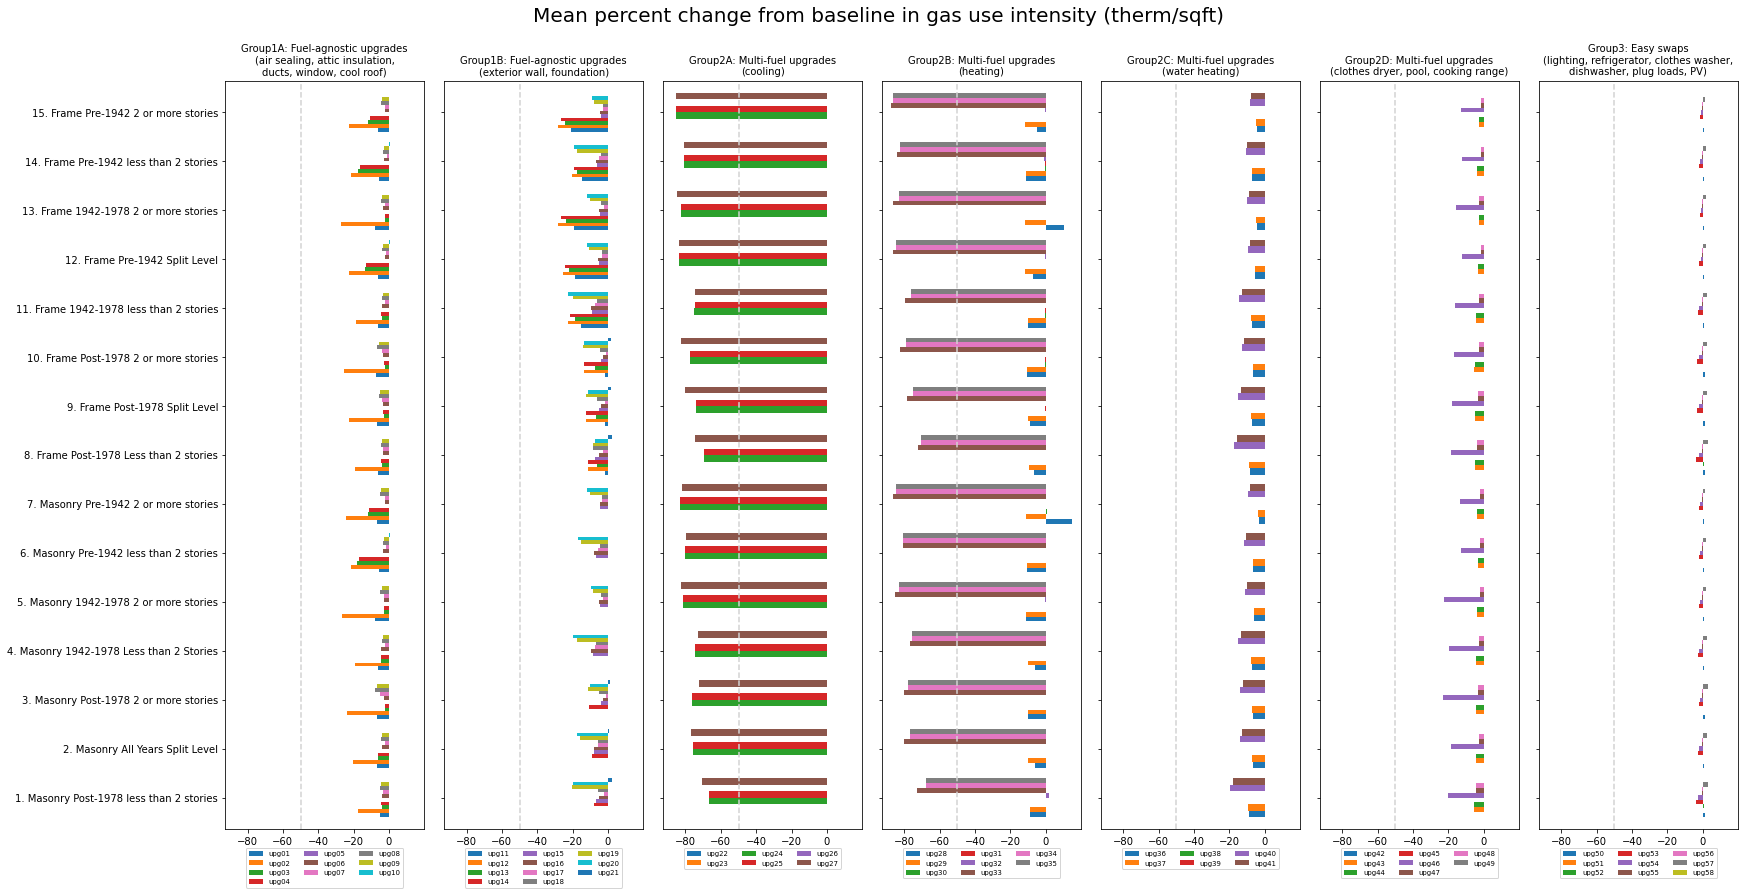

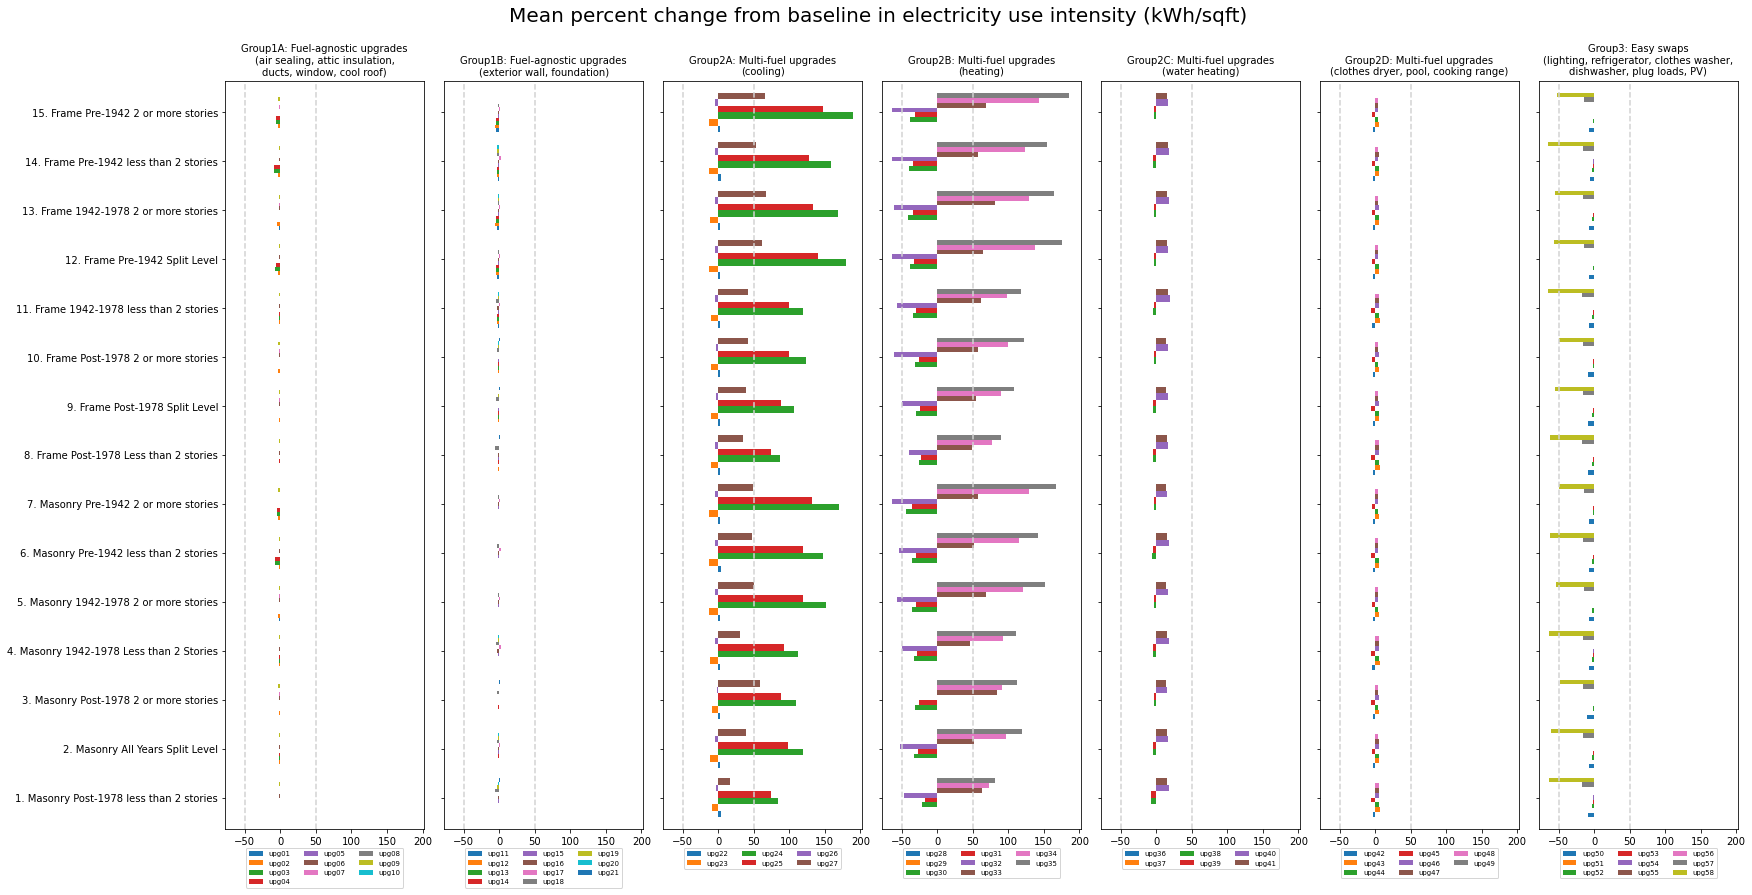

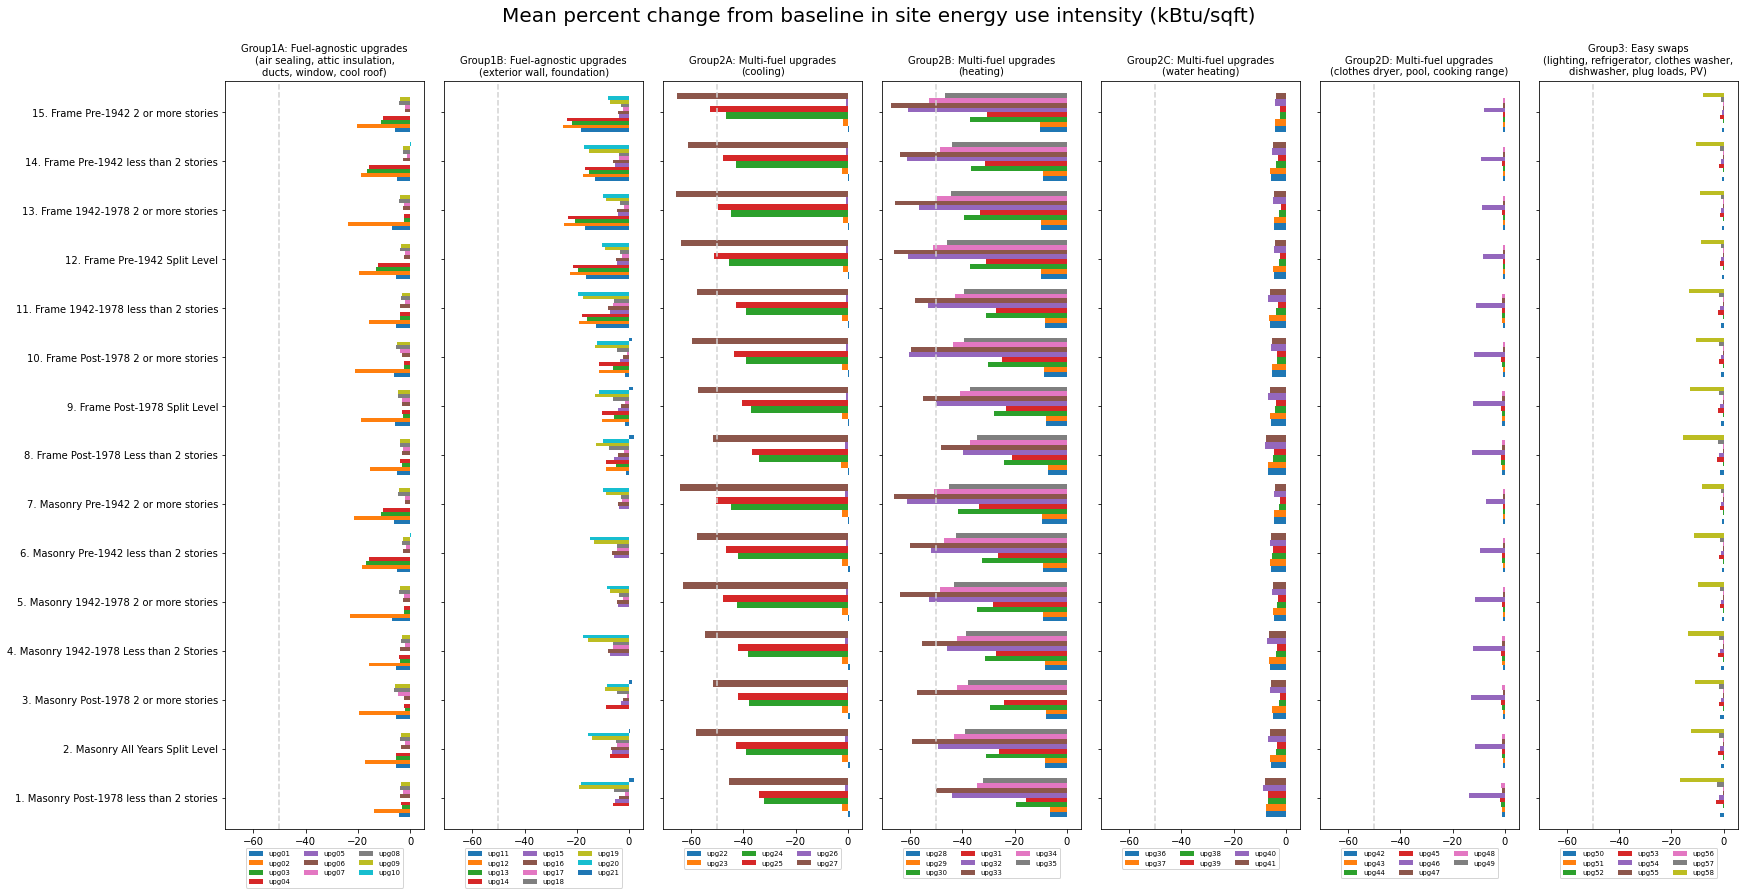

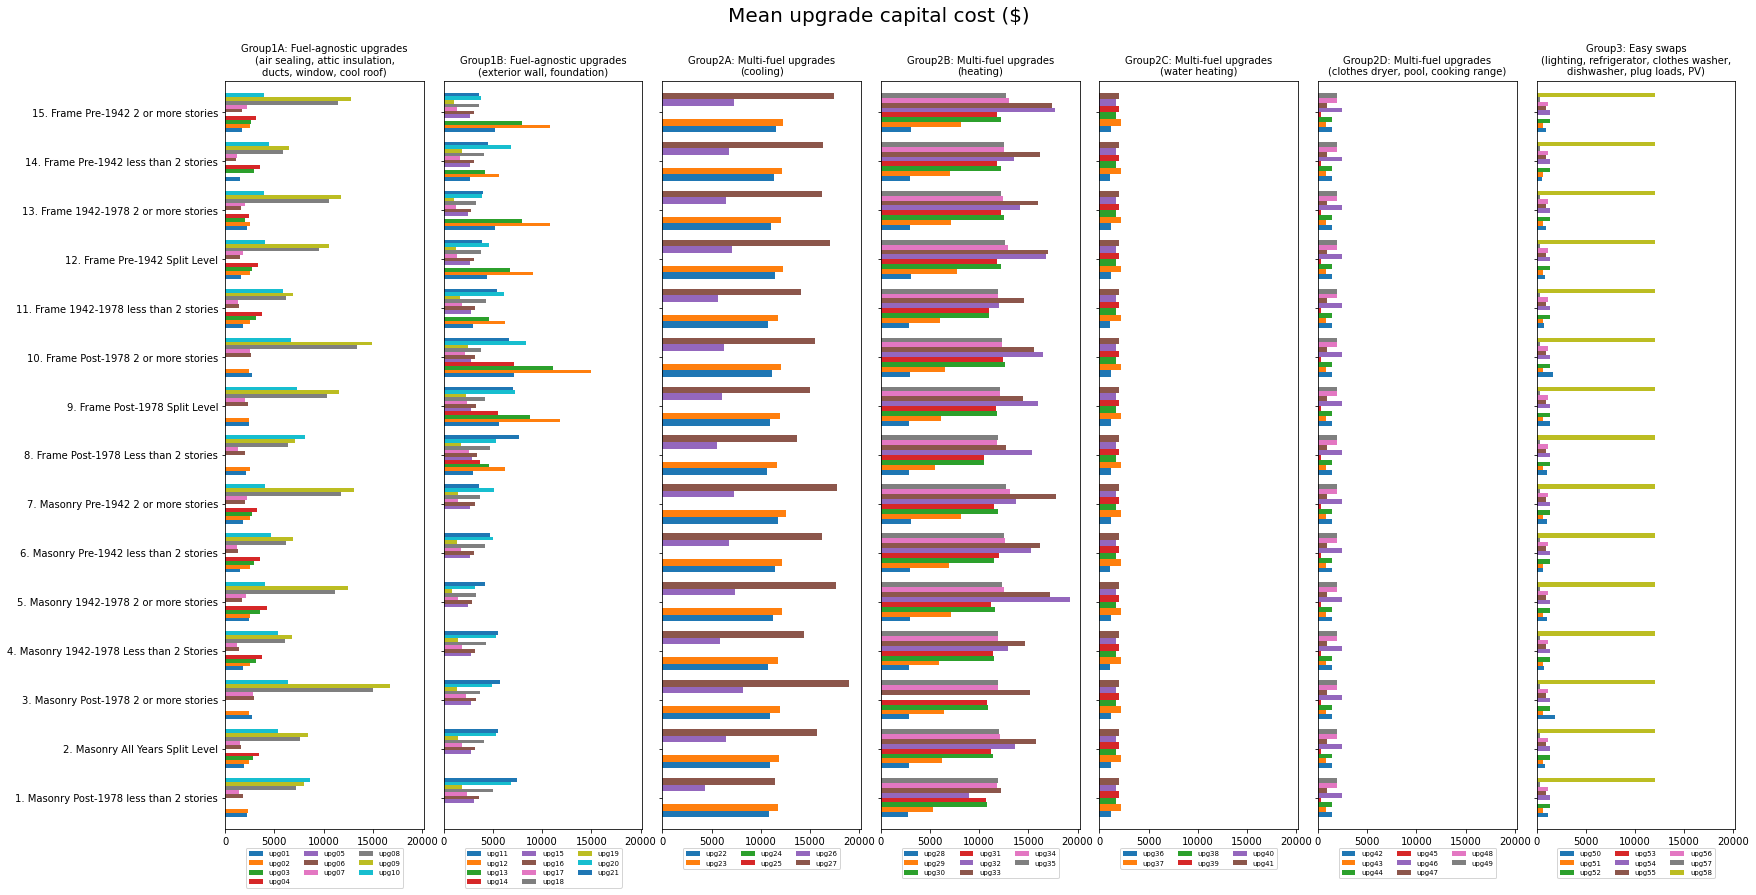

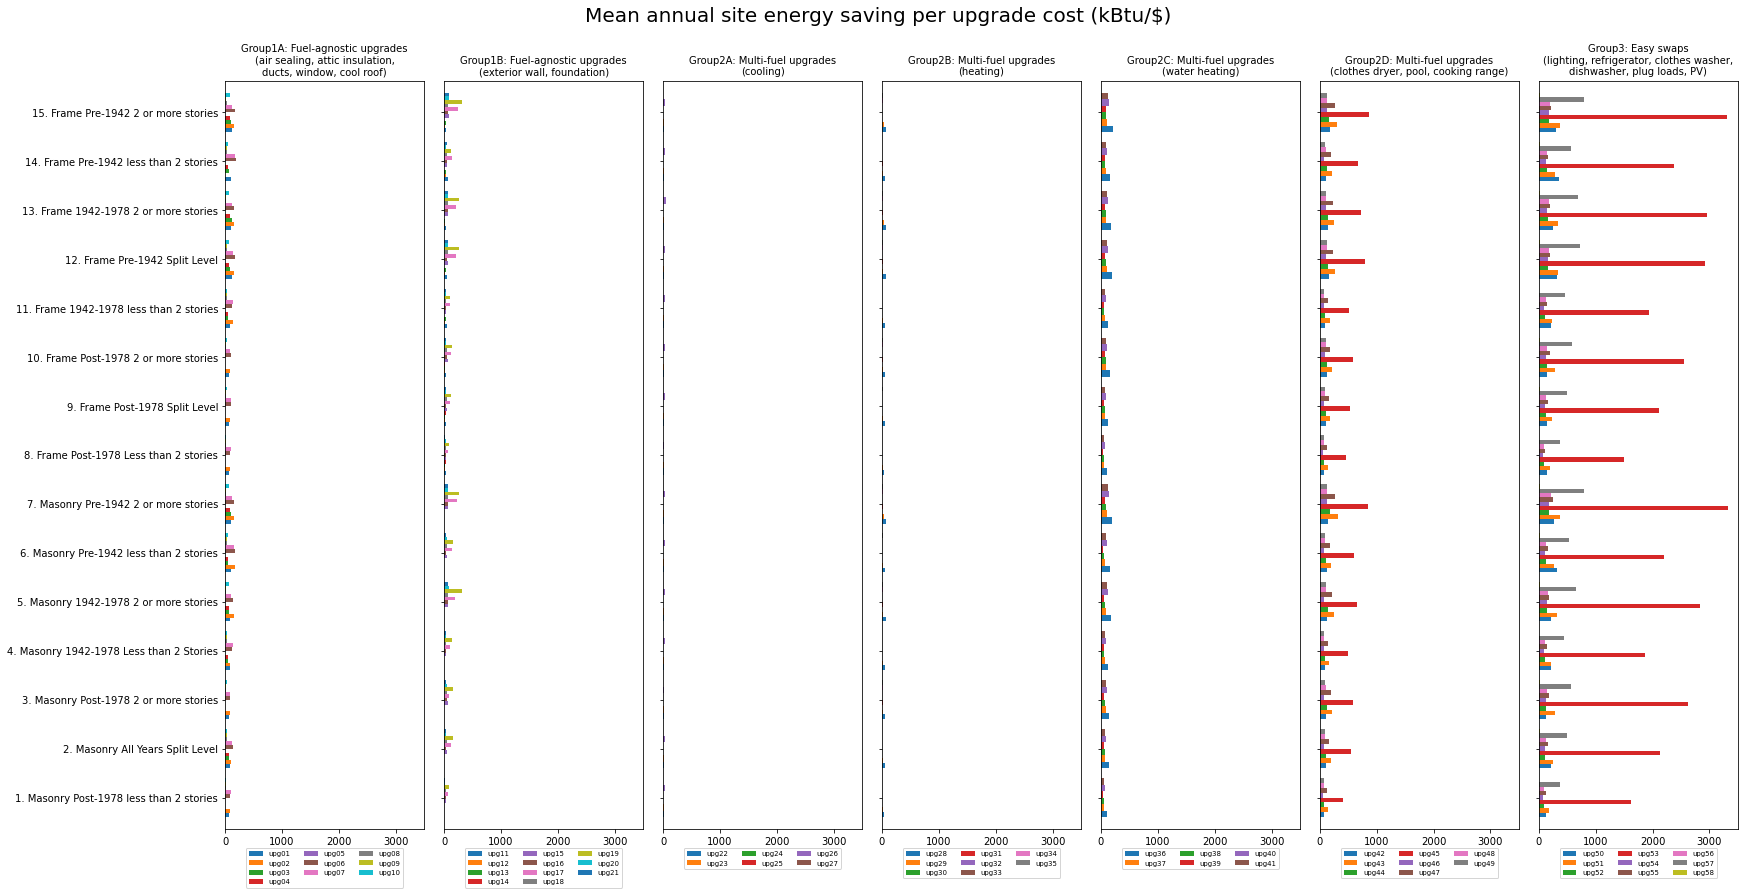

In [125]:
### other metrics to consider:
# energy savings per dollar (gas, elec)
# carbon savings (require timeseries results)

para_labels = {
    'mean_pct_delta_gas_eui': 'Mean percent change from baseline in gas use intensity (therm/sqft)',
    'mean_pct_delta_elec_eui': 'Mean percent change from baseline in electricity use intensity (kWh/sqft)',
    'mean_pct_delta_site_eui': 'Mean percent change from baseline in site energy use intensity (kBtu/sqft)',
    'mean_upgrade_cost': 'Mean upgrade capital cost ($)',
    'mean_kbtu_saved_per_dollar': 'Mean annual site energy saving per upgrade cost (kBtu/$)'
}

for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    print(f'>> {i}. plotting {para_to_plot}...')
    para_label = para_labels[para_to_plot]

    idx = groups2.loc[:,(('Baseline'),('HousingGroupNo'))].astype(str) +'. '+\
          groups2.loc[:,(('Baseline'),('HousingGroupName'))]
    UPs = groups2.set_index(idx)[para_to_plot]
    xmin = UPs.min().min(); xmax = UPs.max().max()

    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(ncols=7, nrows=1, 
                                                            sharex=True, sharey=True, figsize=(3.5*7, 12))

    ### Group 1: Intensive, fuel-agnostic upgrades (upg01-upg21)
    # Group 1A: (upg01-upg10) N=10
    ax = ax1
    Name = 'Group1A: Fuel-agnostic upgrades\n(air sealing, attic insulation,\nducts, window, cool roof)'
    UPi = UPs.iloc[:, :10] 
    UPi.plot(kind='barh', width=0.8, ax=ax)
    if (i<4) & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='lightgray')
    if (i<4) & (xmax > 50):
        ax.axvline(x=50, linestyle='--', color='lightgray')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 1B: (upg11-upg21) N=11
    ax = ax2
    Name = 'Group1B: Fuel-agnostic upgrades\n(exterior wall, foundation)'
    UPi = UPs.iloc[:, 10:21]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    if (i<4) & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='lightgray')
    if (i<4) & (xmax > 50):
        ax.axvline(x=50, linestyle='--', color='lightgray')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)


    ### Group 2: Multi-fuel upgrades (upg22-upg49)
    # Group 2A: (upg22-upg27) N=6
    ax = ax3
    Name = 'Group2A: Multi-fuel upgrades\n(cooling)'
    UPi = UPs.iloc[:, 21:27]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    if (i<4) & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='lightgray')
    if (i<4) & (xmax > 50):
        ax.axvline(x=50, linestyle='--', color='lightgray')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2B: (upg28-upg35) N=7
    ax = ax4
    Name = 'Group2B: Multi-fuel upgrades\n(heating)'
    UPi = UPs.iloc[:, 27:35]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    if (i<4) & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='lightgray')
    if (i<4) & (xmax > 50):
        ax.axvline(x=50, linestyle='--', color='lightgray')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2C: (upg36-upg41) N=6
    ax = ax5
    Name = 'Group2C: Multi-fuel upgrades\n(water heating)'
    UPi = UPs.iloc[:, 35:41]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    if (i<4) & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='lightgray')
    if (i<4) & (xmax > 50):
        ax.axvline(x=50, linestyle='--', color='lightgray')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    # Group 2D: (upg42-upg49) N=8
    ax = ax6
    Name = 'Group2D: Multi-fuel upgrades\n(clothes dryer, pool, cooking range)'
    UPi = UPs.iloc[:, 41:49]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    if (i<4) & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='lightgray')
    if (i<4) & (xmax > 50):
        ax.axvline(x=50, linestyle='--', color='lightgray')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)

    
    ### Group 3: Easy swaps (upg50-upg58) N=9
    ax = ax7
    Name = 'Group3: Easy swaps\n(lighting, refrigerator, clothes washer,\ndishwasher, plug loads, PV)'
    UPi = UPs.iloc[:, 49:]
    UPi.plot(kind='barh', width=0.8, ax=ax)
    if (i<4) & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='lightgray')
    if (i<4) & (xmax > 50):
        ax.axvline(x=50, linestyle='--', color='lightgray')
    ax.set_title(Name, fontsize='medium')
    ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -.02), fontsize='x-small')
    ax.margins(y=0)
    
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

    fig.savefig(os.path.join(result_path, 'upgrades',f'{iter_path}-comparison_{para_to_plot}.pdf'),
                bbox_inches='tight')


In [123]:
os.path.join(result_path, 'baseline',f'{iter_path}-upgrades_comparison.pdf')

'/Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_01/baseline/cookcnty_upgrades_01-upgrades_comparison.pdf'

### 3. Optional: Useful aggregations for diagnosis

### Add additional metrics to ResStock results

In [69]:
### get sqft distr by building type and vintage
res_sqft_distr = res.groupby(['build_existing_model.geometry_building_type_recs', 'build_existing_model.vintage_acs',
    'build_existing_model.geometry_floor_area'])['building_id'].count().to_frame()

# normalize
res_sqft_distr = res_sqft_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=2)

# export
res_sqft_distr.to_csv(os.path.join(result_path, 'baseline', 'building_type_vintage_floor_area.csv'), index=True)
print('sqft distr by vintage & bldg type exported')


sqft distr by vintage & bldg type exported


In [73]:
### get foundation type distr by building type, vintage (EE prototype)
print('>> prevalence')
res_found_distr = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['build_existing_model.geometry_wall_type', 'vintage_ee', 'stories',
    'build_existing_model.geometry_foundation_type'])['building_id'].count().to_frame()

# normalize
res_found_distr = res_found_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=-1)
display(res_found_distr)

print('\n>> gas usage')
res_found_gas = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['build_existing_model.geometry_wall_type', 'vintage_ee', 'stories',
    'build_existing_model.geometry_foundation_type'])[
    'simulation_output_report.total_site_natural_gas_therm'].mean().to_frame()
res_found_gas.unstack(level=-1)


>> prevalence


build_existing_model.geometry_foundation_type                          Crawl  \
build_existing_model.geometry_wall_type vintage_ee   stories                   
Masonry                                 1: pre-1942  1: <2 stories  0.067395   
                                                     2: 2+ stories  0.085610   
                                        2: 1942-1978 1: <2 stories  0.118911   
                                                     2: 2+ stories  0.013690   
                                        3: post-1978 1: <2 stories  0.102585   
                                                     2: 2+ stories  0.077565   
WoodStud                                1: pre-1942  1: <2 stories  0.050282   
                                                     2: 2+ stories  0.123120   
                                        2: 1942-1978 1: <2 stories  0.106988   
                                                     2: 2+ stories  0.043855   
                                        3: post-1978 1: <2 stories  0.075724   
                                                     2: 2+ stories  0.073497   

build_existing_model.geometry_foundation_type                       Heated Basement  \
build_existing_model.geometry_wall_type vintage_ee   stories                          
Masonry                                 1: pre-1942  1: <2 stories         0.141469   
                                                     2: 2+ stories         0.163327   
                                        2: 1942-1978 1: <2 stories         0.381566   
                                                     2: 2+ stories         0.058580   
                                        3: post-1978 1: <2 stories         0.206005   
                                                     2: 2+ stories         0.156797   
WoodStud                                1: pre-1942  1: <2 stories         0.093985   
                                                     2: 2+ stories         0.163534   
                                        2: 1942-1978 1: <2 stories         0.239759   
                                                     2: 2+ stories         0.089398   
                                        3: post-1978 1: <2 stories         0.154417   
                                                     2: 2+ stories         0.195991   

build_existing_model.geometry_foundation_type                       Pier and Beam  \
build_existing_model.geometry_wall_type vintage_ee   stories                        
Masonry                                 1: pre-1942  1: <2 stories       0.011536   
                                                     2: 2+ stories       0.009107   
                                        2: 1942-1978 1: <2 stories       0.014963   
                                                     2: 2+ stories       0.001273   
                                        3: post-1978 1: <2 stories       0.019183   
                                                     2: 2+ stories       0.011676   
WoodStud                                1: pre-1942  1: <2 stories       0.001410   
                                                     2: 2+ stories       0.003759   
                                        2: 1942-1978 1: <2 stories       0.018795   
                                                     2: 2+ stories       0.008434   
                                        3: post-1978 1: <2 stories       0.005197   
                                                     2: 2+ stories       0.008909   

build_existing_model.geometry_foundation_type                           Slab  \
build_existing_model.geometry_wall_type vintage_ee   stories                   
Masonry                                 1: pre-1942  1: <2 stories  0.034608   
                                                     2: 2+ stories  0.051002   
                                        2: 1942-1978 1: <2 stories  0.178606   
                                                     2: 2+ stories  0


>> gas usage


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.geometry_foundation_type                                                                      Crawl   
build_existing_model.geometry_wall_type vintage_ee   stories                                                               
Masonry                                 1: pre-1942  1: <2 stories                                        1940.461603      
                                                     2: 2+ stories                                        2458.390036      
                                        2: 1942-1978 1: <2 stories                                        1569.225704      
                                                     2: 2+ stories                                        2085.599435      
                                        3: post-1978 1: <2 stories                                         997.958444      
                                                     2: 2+ stories                                        1465.916083      
WoodStud                                1: pre-1942  1: <2 stories                                        1832.262789      
                                                     2: 2+ stories                                        2339.902964      
                                        2: 1942-1978 1: <2 stories                                        1563.475069      
                                                     2: 2+ stories                                        2059.848575      
                                        3: post-1978 1: <2 stories                                        1106.906242      
                                                     2: 2+ stories                                        1749.793063      

                                                                                    \
build_existing_model.geometry_foundation_type                      Heated Basement   
build_existing_model.geometry_wall_type vintage_ee   stories                         
Masonry                                 1: pre-1942  1: <2 stories      927.833921   
                                                     2: 2+ stories     1610.622552   
                                        2: 1942-1978 1: <2 stories      849.796824   
                                                     2: 2+ stories     1435.606517   
                                        3: post-1978 1: <2 stories      613.756635   
                                                     2: 2+ stories     1130.098897   
WoodStud                                1: pre-1942  1: <2 stories     1073.996908   
                                                     2: 2+ stories     1659.683948   
                                        2: 1942-1978 1: <2 stories      861.448258   
                                                     2: 2+ stories     1541.657212   
                                        3: post-1978 1: <2 stories      661.310294   
                                                     2: 2+ stories     1143.715722   

                                                                                  \
build_existing_model.geometry_foundation_type                      Pier and Beam   
build_existing_model.geometry_wall_type vintage_ee   stories                       
Masonry                                 1: pre-1942  1: <2 stories   1993.172841   
                                                     2: 2+ stories   2648.913123   
                                        2: 1942-1978 1: <2 stories   1795.871929   
                                                     2: 2+ stories   2183.880144   
                                        3: post-1978 1: <2 stories   1517.001083   
                                                     2: 2+ stories   2047.359080   
WoodStud                                1: pre-1942  1: <2 stories   2367.532625   
                                                     2: 2+ stories   2506.8

In [78]:
res[(res['completed_status']=="Success") &
    (res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")
   ].groupby(['build_existing_model.vintage', 'build_existing_model.geometry_stories'])[
    'simulation_output_report.total_site_natural_gas_therm','gas_eui', 
    'simulation_output_report.total_site_electricity_kwh', 'elec_eui','sqft'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.vintage build_existing_model.geometry_stories                                                          
1940s                        1                                                                            1165.567346       
                             2                                                                            1663.586278       
                             3                                                                            2902.876088       
1950s                        1                                                                            1151.998294       
                             2                                                                            1758.102403       
                             3                                                                            2356.456906       
1960s                        1                                                                            1210.069079       
                             2                                                                            1803.041217       
                             3                                                                            2253.285793       
1970s                        1                                                                            1085.069685       
                             2                                                                            1568.397085       
                             3                                                                            1992.237307       
1980s                        1                                                                            1023.246750       
                             2                                                                            1562.276096       
                             3                                                                            2130.240485       
1990s                        1                                                                             959.363511       
                             2                                                                            1459.369301       
                             3                                                                            2122.163827       
2000s                        1                                                                             744.748035       
                             2                                                                            1074.057426       
                             3                                                                            1340.696042       
2010s                        1                                                                             651.038006       
                             2                                                                            1200.248688       
                             3                                                                            1918.241436       
<1940                        1                                                                            1480.098034       
                             2                                                                            2005.382117       
                             3                                                                            2718.633120       

                                                                     gas_eui  \
build_existing_model.vintage build_existing_model.geometry_stories             
1940s                        1                                      0.785852   
                             2                                      0.897455   
                             3                                      1.158714   
1950s                        1            